<a href="https://colab.research.google.com/github/Loinen/ml_labs/blob/main/ml_stroke_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ПОСТРОЕНИЕ ПРЕДСКАЗАТЕЛЬНОЙ МОДЕЛИ ВОЗНИКНОВЕНИЯ ИНСУЛЬТА

В данной работе будет построена предсказательная модель возникновения инсульта на основе данных о [пациентах](https://www.kaggle.com/fedesoriano/stroke-prediction-dataset) c kaggle.

# 1. Загрузка данных и библиотек

In [337]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings

from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, StratifiedShuffleSplit
from sklearn import model_selection
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.feature_selection import SelectFromModel

import plotly.graph_objs as go

%matplotlib inline

dataset = pd.read_csv("stroke_data.csv")
print(dataset.shape)

(5110, 12)


# 2. Анализ датасета

1.   id: уникальный идентификатор
2.   gender: Male, Female, Other
3.   age: возраст пациента
4.   hypertension: 0, если у пациента нет артериальной гипертензии, 1, если есть
5.   heart_disease: 0, если у пациента нет сердечных заболеваний, 1, если есть
6.   ever_married: No или Yes
7.   work_type: children, Govt_jov, Never_worked, Private или Self-employed - тип занятости
8.   Residence_type: Rural - Сельский или Urban - Городской
9.   avg_gluosis_level: средний уровень глюкозы в крови
10.  bmi: индекс массы тела
11.  smoking_status: статус курения - formerly smoked - «ранее курил», never smoked, smokes или Unknown
12.  stroke: 1, если у пациента был инсульт, или 0, если нет.


In [338]:
dataset.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [339]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [340]:
dataset.drop(columns=['id'], axis = 1, inplace = True)
dataset.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [341]:
print(dataset.value_counts("gender")) # f - 2994, m - 2115, other - 1
print("\n", dataset.value_counts("hypertension")) # 0 - 4612, 1 - 498
print("\n",dataset.value_counts("heart_disease")) # 0 - 4834, 1 - 276
print("\n",dataset.value_counts("ever_married")) # y - 3353, n - 1757
print("\n",dataset.value_counts("work_type")) # Private - 2925, Self-employed - 819, children - 687, Govt_job - 657, Never_worked - 22
print("\n",dataset.value_counts("Residence_type")) #Urban - 2596, Rural - 2514
print("\n",dataset.value_counts("smoking_status")) # never smoked - 1892, Unknown - 1544, formerly smoked - 885, smokes - 789
print("\n",dataset.value_counts("stroke")) # 0 - 4861, 1 - 249

gender
Female    2994
Male      2115
Other        1
dtype: int64

 hypertension
0    4612
1     498
dtype: int64

 heart_disease
0    4834
1     276
dtype: int64

 ever_married
Yes    3353
No     1757
dtype: int64

 work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
dtype: int64

 Residence_type
Urban    2596
Rural    2514
dtype: int64

 smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
dtype: int64

 stroke
0    4861
1     249
dtype: int64


In [342]:
child = dataset.loc[dataset['age'] <= 14]
#print(child.value_counts("work_type")) 
st = child.loc[dataset['stroke'] == 1]
print(st.age) 
# у нас есть достаточно много строк, где возраст явно с ошибками, но судя по worktype большинство из них дети
print("диабетики:", len(dataset.avg_glucose_level.loc[dataset['avg_glucose_level'] >= 125]))
# avg gl - 70 mg/dl - 100 mg/dl  - normal, до 70 - hypoglycemia, от 100 до 125 - prediabetic, до 300 - diabetic
print("гипокликемия:", len(dataset.avg_glucose_level.loc[dataset['avg_glucose_level'] <= 70]))

print(dataset['bmi'].loc[dataset['bmi'] >= 60]) 

# bmi - under_weight до 18.5, normal <25, overweight, <30, obese 40
# у нас есть 13 человек с bmi больше 60 - это может быть вес от 135кг (если 150 см = 60 имт) до 200кг (181кг\150см = 78 имт)
print(dataset.loc[dataset['bmi'] <= 16].value_counts("stroke")) 
# Низкие значения имт - в основном у детей, для них норма ниже

162     1.32
245    14.00
Name: age, dtype: float64
диабетики: 1000
гипокликемия: 756
270     60.9
358     64.8
466     60.2
544     71.9
928     78.0
1559    66.8
2128    97.6
2764    63.3
2840    61.2
3825    61.6
4188    64.4
4209    92.0
4838    60.9
Name: bmi, dtype: float64
stroke
0    92
dtype: int64


stroke (249, 11) no_stroke (4861, 11)


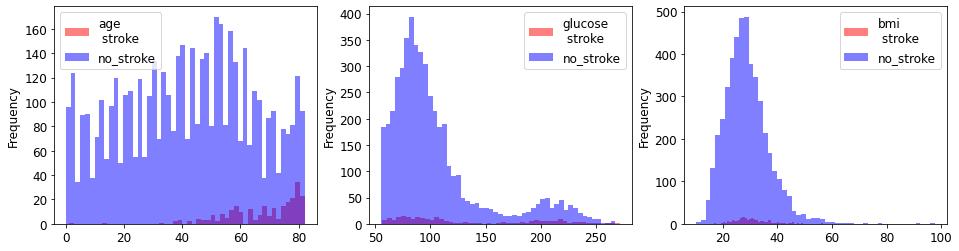

In [343]:
stroke = dataset[dataset.stroke == 1]
no_stroke = dataset[dataset.stroke == 0]
print("stroke", stroke.shape, "no_stroke", no_stroke.shape)

plt.rcParams.update({'font.size': 12})
fig, axs = plt.subplots(ncols=3, figsize=(16, 4))

stroke["age"].plot.hist(alpha=0.5,color='red',bins=50, ax=axs[0])
no_stroke["age"].plot.hist(alpha=0.5,color='blue',bins=50, ax=axs[0])
axs[0].legend(['age\n stroke','no_stroke'])

stroke["avg_glucose_level"].plot.hist(alpha=0.5,color='red',bins=50, ax=axs[1])
no_stroke["avg_glucose_level"].plot.hist(alpha=0.5,color='blue',bins=50, ax=axs[1])
axs[1].legend(['glucose\n stroke','no_stroke'])

stroke["bmi"].plot.hist(alpha=0.5,color='red',bins=50, ax=axs[2])
no_stroke["bmi"].plot.hist(alpha=0.5,color='blue',bins=50, ax=axs[2])
axs[2].legend(['bmi\n stroke','no_stroke'])

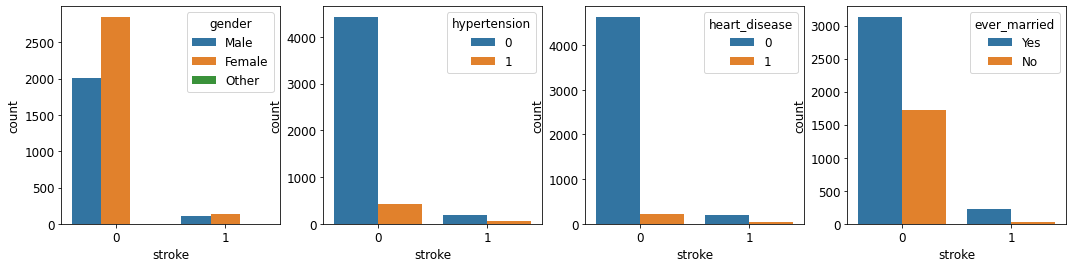

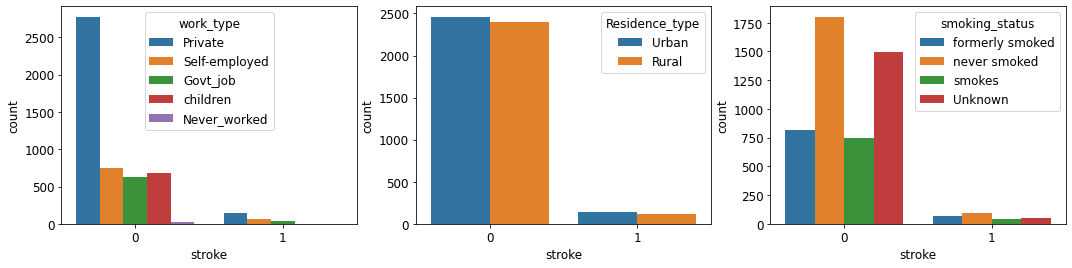

In [344]:
plt.rcParams.update({'font.size': 12})
fig, axs = plt.subplots(ncols=4, figsize=(18, 4))
sns.countplot(x="stroke",data=dataset,hue='gender', ax=axs[0])
sns.countplot(x="stroke",data=dataset,hue='hypertension', ax=axs[1])
sns.countplot(x="stroke",data=dataset,hue='heart_disease', ax=axs[2])
sns.countplot(x="stroke",data=dataset,hue='ever_married', ax=axs[3])
fig, axs = plt.subplots(ncols=3, figsize=(18, 4))
sns.countplot(x="stroke",data=dataset,hue='work_type', ax=axs[0])
sns.countplot(x="stroke",data=dataset,hue='Residence_type', ax=axs[1])
sns.countplot(x="stroke",data=dataset,hue='smoking_status', ax=axs[2])

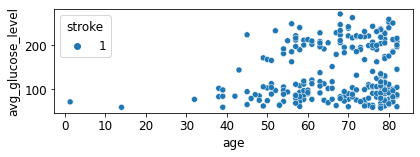

In [345]:
plt.subplot(2,1,2)
sns.scatterplot(x=stroke['age'],y=stroke['avg_glucose_level'],hue=stroke['stroke'])
plt.tight_layout()
plt.show()

In [346]:
dataset.corr()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
age,1.000000,0.276398,0.263796,0.238171,0.333398,0.245257
hypertension,0.276398,1.000000,0.108306,0.174474,0.167811,0.127904
heart_disease,0.263796,0.108306,1.000000,0.161857,0.041357,0.134914
avg_glucose_level,0.238171,0.174474,0.161857,1.000000,0.175502,0.131945
bmi,0.333398,0.167811,0.041357,0.175502,1.000000,0.042374
stroke,0.245257,0.127904,0.134914,0.131945,0.042374,1.000000


# 3. Предобработка данных
Видно, что у нас есть пропуски в bmi, а также есть пациенты, у которых неизвестен статус курения. Необходимо обработать эти значения, а также преобразовать категориальные признаки - age, work_type.
Бинарные признаки - hypertension, heart_disease, Residence_type, ever_married, gender (other всего один, можно его отбросить).
Столбец id отбросим. 
Признаки age, work_type,  можно преобразовать, разделив возраст на категории и проведя бинаризацию, для  bmi необходимо заполнить пропуски

(5110, 11)
gender
Female    2994
Male      2115
dtype: int64
(5109, 11)


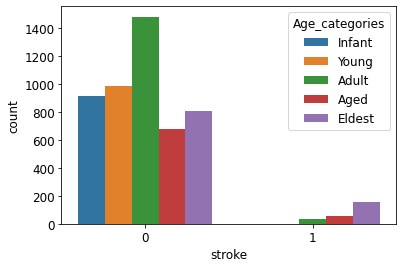

In [347]:
# Удалим лишнего пациента с "другим" полом 
print(dataset.shape)
dataset = dataset.drop(np.where(dataset['gender'] == "Other")[0])
print(dataset.value_counts("gender"))
print(dataset.shape)

# Преобразуем возраст в категориальный признак. 
def process_age(df, cut_points, label_names):
    df['age'] = df['age'].replace(np.NaN, -0.5) #fillna
    df['Age_categories'] = pd.cut(df['age'], bins=cut_points, labels=label_names)
    return df

# Нас в основном интересуют пациенты с возрастом от 35-55 до 80. 
cut_points = [0, 18, 35, 55, 65, 100]
label_names = ["Infant", "Young", "Adult", "Aged", "Eldest"]
dataset = process_age(dataset, cut_points, label_names)

sns.countplot(x="stroke",data=dataset,hue='Age_categories')

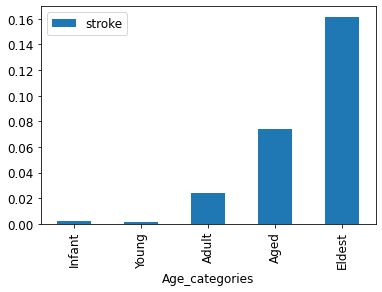

In [348]:
age_cat_pivot = dataset.pivot_table(index="Age_categories",values="stroke")
age_cat_pivot.plot.bar()
plt.show()

In [349]:
def create_dummies(df, column_name):
    dum = pd.get_dummies(df[column_name], prefix=column_name)
    df = pd.concat([df,dum],axis=1)
    return df

dataset = create_dummies(dataset, "gender")
dataset = create_dummies(dataset, "work_type")
dataset = create_dummies(dataset, "Age_categories")

In [350]:
dataset = dataset.drop(columns=['gender', 'age', 'ever_married', "work_type", "Age_categories", "Residence_type", "smoking_status"], axis=1)

In [351]:
miss_bmi = dataset[dataset.bmi.isna()]
print("missing:", len(miss_bmi))
print("missing with stroke:", len(miss_bmi[miss_bmi.stroke == 1]))
print("В наборе данных у 40 из 249 пациентов с инсультом неизвестен ИМТ")

missing: 201
missing with stroke: 40
В наборе данных у 40 из 249 пациентов с инсультом неизвестен ИМТ


In [352]:
dataset.corr()

,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Age_categories_Infant,Age_categories_Young,Age_categories_Adult,Age_categories_Aged,Age_categories_Eldest
hypertension,1.000000,0.108292,0.174540,0.167770,0.127891,-0.021223,0.021223,0.017661,-0.021612,-0.005358,0.115417,-0.129535,-0.151884,-0.128488,-0.012534,0.082445,0.219069
heart_disease,0.108292,1.000000,0.161907,0.041322,0.134905,-0.085685,0.085685,0.001312,-0.015715,0.000068,0.086742,-0.091654,-0.109437,-0.112175,-0.077429,0.038351,0.276218
avg_glucose_level,0.174540,0.161907,1.000000,0.175672,0.131991,-0.054722,0.054722,0.013908,-0.014665,0.016451,0.062770,-0.102195,-0.117384,-0.136431,-0.020209,0.092376,0.193326
bmi,0.167770,0.041322,0.175672,1.000000,0.042341,0.026164,-0.026164,0.079526,-0.028615,0.208205,0.072634,-0.448779,-0.431770,0.015241,0.224344,0.131400,0.031260
stroke,0.127891,0.134905,0.131991,0.042341,1.000000,-0.009081,0.009081,0.002660,-0.014885,0.011927,0.062150,-0.083888,-0.101056,-0.108106,-0.075308,0.047698,0.253072
gender_Female,-0.021223,-0.085685,-0.054722,0.026164,-0.009081,1.000000,-1.000000,0.016598,-0.011486,0.032502,0.026045,-0.089226,-0.088884,0.073141,0.029733,-0.031078,0.006585
gender_Male,0.021223,0.085685,0.054722,-0.026164,0.009081,-1.000000,1.000000,-0.016598,0.011486,-0.032502,-0.026045,0.089226,0.088884,-0.073141,-0.029733,0.031078,-0.006585
work_type_Govt_job,0.017661,0.001312,0.013908,0.079526,0.002660,0.016598,-0.016598,1.000000,-0.025263,-0.444394,-0.167849,-0.151417,-0.165834,-0.038999,0.132087,0.055098,-0.001637
work_type_Never_worked,-0.021612,-0.015715,-0.014665,-0.028615,-0.014885,-0.011486,0.011486,-0.025263,1.000000,-0.076075,-0.028734,-0.025921,0.125115,-0.016907,-0.042697,-0.026872,-0.031735
work_type_Private,-0.005358,0.000068,0.016451,0.208205,0.011927,0.032502,-0.032502,-0.444394,-0.076075,1.000000,-0.505448,-0.455965,-0.349888,0.251991,0.110815,0.039129,-0.075091


In [353]:
# пробуем предсказать имт, вместо медианы\среднего
data = dataset.copy()
data = data[~data.bmi.isna()]
print(data.shape)
y = data['bmi']

data = data[["hypertension", 'avg_glucose_level', 'work_type_children', 
             'Age_categories_Infant', 'Age_categories_Young', 'Age_categories_Adult', 'Age_categories_Aged', 'Age_categories_Eldest']]

(4908, 17)


In [354]:
from sklearn.ensemble import GradientBoostingRegressor

x_train, x_test, y_train, y_test = train_test_split(data, y, train_size=0.8, random_state=42)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape) 

model = Pipeline( steps=[ ('scale',StandardScaler()),
                          ('lr',GradientBoostingRegressor(random_state=42))])
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

print('Предсказанные значения:\n', np.around(list(y_pred[:50]), 1))
print('Истинные значения:\n', np.around(list(y_test[:50]), 1))

(3926, 8) (982, 8) (3926,) (982,)
Предсказанные значения:
 [29.5 30.8 30.1 29.1 30.9 28.2 29.5 28.2 30.5 25.7 29.3 28.8 30.8 29.
 30.2 39.9 28.7 29.3 30.9 30.9 30.9 30.9 35.3 30.9 30.5 30.6 30.4 26.3
 27.6 29.2 33.6 29.1 33.8 29.1 19.7 29.9 29.9 30.9 31.9 30.8 30.7 32.7
 19.7 29.8 19.7 29.3 20.3 29.8 29.  29. ]
Истинные значения:
 [32.3 31.4 32.1 25.3 22.2 20.1 23.2 30.3 24.8 21.2 32.  24.4 26.4 16.9
 30.5 35.1 23.6 35.3 32.4 22.7 23.1 24.1 38.9 39.1 17.3 33.7 37.7 22.6
 36.4 29.2 28.4 28.4 24.6 46.5 18.4 35.5 27.9 21.5 24.1 44.  28.1 37.4
 27.5 52.8 20.5 29.6 18.6 37.  41.3 43. ]


In [355]:
from sklearn.metrics import r2_score

train = pd.concat([x_train,y_train],axis=1)
test = pd.concat([x_test,y_test],axis=1)
y_pred = test.copy()

bmi_mean = np.mean(train['bmi'])
y_pred['bmi'] = bmi_mean
print('Model score:', model.score(x_test, y_test))
print('Mean score: ', r2_score(y_test, y_pred.bmi)) # Model score: 0.24322853880598097
# видно, что модель дает хоть и не очень точные, но достаточно качественные значения, в отличие от усреднения

Model score: 0.24322853880598097
Mean score:  -0.0011478514902276693


In [356]:
# Теперь предскажем имт для NAN
model = Pipeline( steps=[ ('scale',StandardScaler()),
                          ('lr',GradientBoostingRegressor(random_state=42))])
model.fit(data, y)

X = miss_bmi[["hypertension", 'avg_glucose_level', 'work_type_children', 
             'Age_categories_Infant', 'Age_categories_Young', 'Age_categories_Adult', 'Age_categories_Aged', 'Age_categories_Eldest']]
y_pred = model.predict(X)
dataset = dataset.copy()
dataset.loc[miss_bmi.index,'bmi'] = pd.Series(y_pred,index=miss_bmi.index)

In [357]:
dataset.head(5)

,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Age_categories_Infant,Age_categories_Young,Age_categories_Adult,Age_categories_Aged,Age_categories_Eldest
0,0,1,228.69,36.600000,1,0,1,0,0,1,0,0,0,0,0,0,1
1,0,0,202.21,35.270048,1,1,0,0,0,0,1,0,0,0,0,1,0
2,0,1,105.92,32.500000,1,0,1,0,0,1,0,0,0,0,0,0,1
3,0,0,171.23,34.400000,1,1,0,0,0,1,0,0,0,0,1,0,0
4,1,0,174.12,24.000000,1,1,0,0,0,0,1,0,0,0,0,0,1


In [358]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 0 to 5109
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   hypertension             5109 non-null   int64  
 1   heart_disease            5109 non-null   int64  
 2   avg_glucose_level        5109 non-null   float64
 3   bmi                      5109 non-null   float64
 4   stroke                   5109 non-null   int64  
 5   gender_Female            5109 non-null   uint8  
 6   gender_Male              5109 non-null   uint8  
 7   work_type_Govt_job       5109 non-null   uint8  
 8   work_type_Never_worked   5109 non-null   uint8  
 9   work_type_Private        5109 non-null   uint8  
 10  work_type_Self-employed  5109 non-null   uint8  
 11  work_type_children       5109 non-null   uint8  
 12  Age_categories_Infant    5109 non-null   uint8  
 13  Age_categories_Young     5109 non-null   uint8  
 14  Age_categories_Adult    

In [359]:
dataset.describe()

,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Age_categories_Infant,Age_categories_Young,Age_categories_Adult,Age_categories_Aged,Age_categories_Eldest
count,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000,5109.000000
mean,0.097475,0.054022,106.140399,28.953612,0.048738,0.586025,0.413975,0.128597,0.004306,0.572323,0.160305,0.134469,0.179291,0.192210,0.296536,0.143081,0.188882
std,0.296633,0.226084,45.285004,7.744213,0.215340,0.492592,0.492592,0.334786,0.065486,0.494790,0.366925,0.341188,0.383634,0.394076,0.456775,0.350190,0.391453
min,0.000000,0.000000,55.120000,10.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,77.240000,23.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,91.880000,28.300000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,114.090000,33.100000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,271.740000,97.600000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


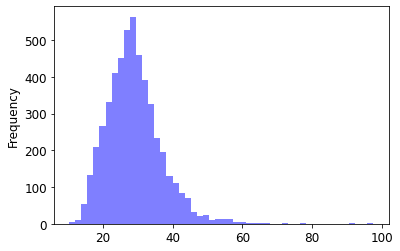

In [360]:
dataset["bmi"].plot.hist(alpha=0.5,color='blue',bins=50)

In [361]:
corr_matrix = dataset.corr()
corr_matrix["stroke"].sort_values(ascending=False) 

stroke                     1.000000
Age_categories_Eldest      0.253072
heart_disease              0.134905
avg_glucose_level          0.131991
hypertension               0.127891
work_type_Self-employed    0.062150
Age_categories_Aged        0.047698
bmi                        0.042067
work_type_Private          0.011927
gender_Male                0.009081
work_type_Govt_job         0.002660
gender_Female             -0.009081
work_type_Never_worked    -0.014885
Age_categories_Adult      -0.075308
work_type_children        -0.083888
Age_categories_Infant     -0.101056
Age_categories_Young      -0.108106
Name: stroke, dtype: float64

# 4. Обучение и настройка гиперпараметров моделей
Используемые модели:
1. Логистическую регрессию (`LogisticRegression`).
1. Метод опорных векторов (`SVC`).
1. Наивный байесовский классификатор (`MultinomialNB`).
1. Деревья решений (`DecisionTreeClassifier`).
1. Случайный лес (`RandomForestClassifier`).
1. AdaBoost (`AdaBoost`).
1. Градиентный бустинг (`GradientBoostingClassifier`).
1. Бэггинг (`BaggingClassifier`)




In [362]:
y = dataset['stroke']
X = dataset[['gender_Female', 'gender_Male','avg_glucose_level','bmi', 
             'work_type_Govt_job', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed',
             "hypertension", "heart_disease",
             'Age_categories_Infant', 'Age_categories_Young', 'Age_categories_Adult', 'Age_categories_Aged',
             'Age_categories_Eldest']] #X.drop(columns=drop_cols, axis=1)

sss = StratifiedShuffleSplit(n_splits=5, train_size=0.7, random_state=42)
sss.get_n_splits(X, y)
print(sss)
for train_index, test_index in sss.split(X, y):
    x_train, x_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

print(y_train.value_counts(), y_test.value_counts()) # Видим, что распределение классов сохранено

StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=None,
            train_size=0.7)
0    3402
1     174
Name: stroke, dtype: int64 0    1458
1      75
Name: stroke, dtype: int64


Выбираем с использованием `Pipeline` и `GridSearchCV` оптимальную архитектуру:


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
model best score:  0.8626897683322264
{'clf__C': 0.2, 'clf__class_weight': {0: 1, 1: 10}, 'clf__max_iter': 2000, 'clf__solver': 'saga', 'poly__degree': 2}
model test score:  0.9510763209393346
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      1533
           1       0.00      0.00      0.00         0

    accuracy                           0.95      1533
   macro avg       0.50      0.48      0.49      1533
weighted avg       1.00      0.95      0.97      1533



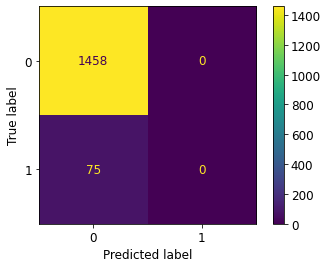

<class 'AttributeError'>
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [ ]:
warnings.filterwarnings('ignore') 

classifiers = [
    LogisticRegression(),
    SVC(),
    MultinomialNB(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    BaggingClassifier()
    ]

# LogisticRegression()
params1 = {"poly__degree": range(1,3,1), 'clf__C': [0.1, 0.2, 0.05], 
           "clf__solver": ['newton-cg', 'lbfgs', 'sag', 'saga'], "clf__max_iter": [2000,3000], 
           "clf__class_weight": ["balanced", {0:1,1:15}, {0:1,1:10}]
           } 
# SVC
params2 = {"poly__degree": range(1,3,1), "clf__kernel":["rbf", "poly", "linear", "sigmoid"], 
           "clf__gamma": ["auto", "scale"], "clf__degree":range(1,6,1), 
           "clf__class_weight": ["balanced", {0:1,1:15}, {0:1,1:20}, {0:1,1:10}]}
# MultinomialNB()
params3 = {"poly__degree": range(1,3,1),"clf__fit_prior": ['True', 'False'],
           "clf__alpha": np.arange(0.8,1.2,0.1), "clf__class_prior": [[.2,.8],[.8, .2]]} # no none
# DecisionTreeClassifier()
params4 = {"poly__degree": range(1,3,1),"clf__criterion":["gini", "entropy"], 
           "clf__max_depth": range(10,15,1),"clf__min_samples_leaf": range(8,14,1), 
           "clf__min_samples_split": range(2,10,2), "clf__class_weight": ["balanced", {0:1,1:15}] }   
# RandomForestClassifier()
params5 = {"poly__degree": range(1,3,1),"clf__criterion":["gini", "entropy"], "clf__max_depth": range(10,15,1),
           "clf__class_weight":["balanced", "balanced_subsample", {0:1,1:15}, {0:1,1:20}, {0:1,1:10}], 
            "clf__min_samples_leaf": range(7,14,1), "clf__n_estimators":range(50,150,50)} 
# AdaBoostClassifier()
params6 = {"poly__degree": range(1,3,1),"clf__learning_rate":np.arange(0.2,1,0.2), 
           "clf__n_estimators":range(20,60,20), "clf__algorithm":["SAMME", "SAMME.R"],
           "clf__base_estimator":[SVC(class_weight={0: 1, 1: 10},kernel='sigmoid',degree=1, gamma="auto"),
                                  SVC(class_weight={0: 1, 1: 10},kernel='poly',degree=2, gamma="auto"), 
                                  SVC(class_weight={0: 1, 1: 10},kernel='poly',degree=1, gamma="auto")]
           } 
# GradientBoostingClassifier()
params7 = {"poly__degree": range(1,3,1),"clf__loss":["deviance", "exponential"], 
           "clf__learning_rate":[0.09,0.1,0.08], "clf__n_estimators":range(20,100,40),
           "clf__min_samples_leaf": [1,2,3], "clf__max_depth": range(10,14,2)}
# BaggingClassifier()
params8 = {"poly__degree": range(1,2,1),
           "clf__base_estimator":[DecisionTreeClassifier(class_weight={0: 1, 1: 15}, criterion='gini', 
                                  max_depth=10, min_samples_leaf=9, min_samples_split=2),
                                  SVC(class_weight={0: 1, 1: 10},kernel='poly',degree=1, gamma="auto")],
           "clf__n_estimators":range(10,50,20), "clf__max_samples":[0.5, 1.0], "clf__max_features":[0.5, 1.0]
           }
parameters = [params1, params2, params3, params4, params5, params6, params7, params8]
i = 0

kfolds = StratifiedKFold(5, random_state=42)
for classifier in classifiers:
    print(classifier)
    pipe = Pipeline(steps=[('feature_selection', SelectFromModel(LinearSVC(C=0.01, penalty="l2", dual=False,max_iter=2000, random_state=42))),
                            ('scaler', MinMaxScaler()), #MinMaxScaler() StandardScaler()
                            ('poly', PolynomialFeatures()),
                            ('clf', classifier) 
                      ])
    grid_cv = model_selection.GridSearchCV(pipe, parameters[i], scoring='recall_micro', cv=kfolds.split(x_train,y_train)) 
    grid_cv.fit(x_train, y_train)
    print("model best score: ", grid_cv.best_score_)    
    print(grid_cv.best_params_)
    model = grid_cv.best_estimator_
    print("model test score: ", model.score(x_test, y_test))

    y_pred = model.predict(x_test)
    print(classification_report(y_pred,y_test))
    plot_confusion_matrix(model, x_test, y_test, values_format='d')
    plt.show()
    try:      
      fig = go.Figure()
      fig.add_trace(go.Bar(x=x_test.columns,y = model['clf'].feature_importances_))
      fig.update_layout(title='Feature selection results',xaxis_title='Model',yaxis_title='F1 Score')
      fig.show()
    except AttributeError:
      print(AttributeError)

    i+=1

Теперь попробуем без feature selection

In [ ]:
warnings.filterwarnings('ignore') 
i = 0
for classifier in classifiers:
    print(classifier)
    pipe = Pipeline(steps=[
                            ('scaler', MinMaxScaler()), #MinMaxScaler() StandardScaler()
                            ('poly', PolynomialFeatures()),
                            ('clf', classifier) 
                      ])
    grid_cv = model_selection.GridSearchCV(pipe, parameters[i], scoring='recall_micro', cv=kfolds.split(x_train,y_train)) 
    grid_cv.fit(x_train, y_train)
    print("model best score: ", grid_cv.best_score_)    
    print(grid_cv.best_params_)
    model = grid_cv.best_estimator_
    print("model test score: ", model.score(x_test, y_test))

    y_pred = model.predict(x_test)
    print(classification_report(y_pred,y_test))
    plot_confusion_matrix(model, x_test, y_test, values_format='d')
    plt.show()
    try:      
      fig = go.Figure()
      fig.add_trace(go.Bar(x=x_test.columns,y = model['clf'].feature_importances_))
      fig.update_layout(title='Feature selection results',xaxis_title='Model',yaxis_title='F1 Score')
      fig.show()
    except AttributeError:
      print(AttributeError)

    i+=1

In [ ]:
# RandomForestClassifier()
rfc = {"clf__criterion":["gini", "entropy"], "clf__class_weight":["balanced", "balanced_subsample"], 
           "clf__max_depth": range(6,12,2), "clf__min_samples_leaf": range(5,9,1), "clf__n_estimators":[50,100]} 
pipe = Pipeline(steps=[     ('scaler', MinMaxScaler()), #MinMaxScaler() StandardScaler()
                            ('poly', PolynomialFeatures()),
                            ('clf', RandomForestClassifier()) 
                      ])
grid_cv = model_selection.GridSearchCV(pipe, rfc, scoring='f1')
grid_cv.fit(x_train, y_train)
print("model best score: ", grid_cv.best_score_)    
print(grid_cv.best_params_)
model = grid_cv.best_estimator_

In [ ]:
y_pred = model.predict(x_test)

In [ ]:
# посмотрим, какие случаи не предсказала  модель
real = pd.concat([x_test, y_test], axis=1)
pred = real.copy()
pred["stroke2"] = y_pred
print(pred.shape, real.shape)

pred = pd.concat([real, pred.stroke2], axis=1)
real = real[real.stroke == 1]
pred = pred[pred.stroke2 == 1]
print(pred.shape)

In [ ]:
pd.options.display.max_rows = 210
pred # 156

In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(x=x_test.columns,y = model['clf'].feature_importances_))
fig.update_layout(title='The Importance Of The Original Attributes On Our Prediction',xaxis_title='Model',yaxis_title='F1 Score')
fig.show()

In [ ]:
print(classification_report(y_pred,y_test))

In [ ]:
plot_confusion_matrix(model, x_test, y_test, values_format='d')